In [1]:
# !pip install gnss_lib_py|

In [2]:
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pandas as pd

https://drive.google.com/drive/folders/17vNrS_-Kq0msv2r9VHDkry3aEAxUcdAS

### Pseudorange computation

In [75]:
def compute_pseudoranges(raw_data):
    nanosecs_in_week = 604800e9
    speed_of_light = 299792458
    week_no = np.floor(-raw_data['FullBiasNanos']/nanosecs_in_week)
    corrected_rx_time = raw_data['TimeNanos'] + raw_data['TimeOffsetNanos']
    adjusted_rx_bias = raw_data['FullBiasNanos'] + raw_data['BiasNanos']
    rx_time_gps_frame = corrected_rx_time - adjusted_rx_bias
    rx_time_week_frame = rx_time_gps_frame - week_no * nanosecs_in_week
    rho_nanosecs = rx_time_week_frame - raw_data['ReceivedSvTimeNanos']
    rho_m = rho_nanosecs * speed_of_light/1e9
    return rho_m

In [76]:
rover_path = './Oval/RoundLoop1_gnss_log_2024_11_17_16_52_31.txt'
base_path = './Oval/RoundLoop1_BaseStation_gnss_log_2024_11_17_16_52_30.txt'

In [77]:
rover_data = glp.AndroidRawGnss(input_path=rover_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)
rover_data['TimeNanos'] = rover_data['TimeNanos'] - 604800e9
base_data = glp.AndroidRawGnss(input_path=base_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)


sv_time_uncertainty removed 1
sv_time_uncertainty removed 1


In [78]:
rover_data_gps_only = rover_data.where('gnss_id', ('gps'), 'eq')
base_data_gps_only = base_data.where('gnss_id', ('gps'), 'eq')

In [80]:
rho_3 = compute_pseudoranges(rover_data_gps_only)
rho_1 = compute_pseudoranges(base_data)
rho_2 = compute_pseudoranges(base_data_gps_only)

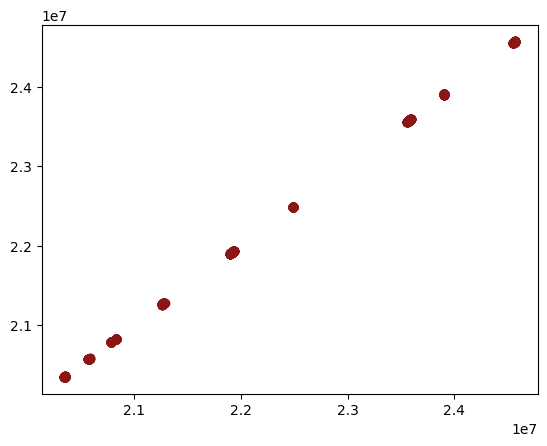

In [81]:
plt.scatter(rho_3, rho_3)

In [83]:
rover_rho = compute_pseudoranges(rover_data_gps_only)

In [186]:
def compute_and_match_pr(rover_data, base_data):
    base_rho = []
    base_matched_data = []
    time_tolerance = 5000
    for i in range(len(rover_data_gps_only)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        a = base_data.where("sv_id", sv_id[i], "eq")
        b = a.where("gnss_id", gnss_id[i], "eq")
        c = b.where("gps_millis", gps_millis[i]-time_tolerance, "geq").where("gps_millis", gps_millis[i]+time_tolerance, "leq")
        rho_vals = compute_pseudoranges(c)
        try: 
            if len(rho_vals) > 0:
                rho_m = rho_vals[0]
                c_val = c.array[:, 0]
            else:
                rho_m = np.nan
                c_val = np.nan
        except:
            rho_m = rho_vals
            c_val = c.array[:, 0]
        base_rho.append(rho_m)
        base_matched_data.append(c_val)
    return base_matched_data, base_rho
matched_base_data, base_rho = compute_and_match_pr(rover_data_gps_only, base_data_gps_only)
base_rho = np.array(base_rho)

Rover data uses sv id of 2, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368439.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368439.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368439.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926368439.0
Rover data

### Verifying that the rover is matched well to base measurements

(20000000.0, 25000000.0)

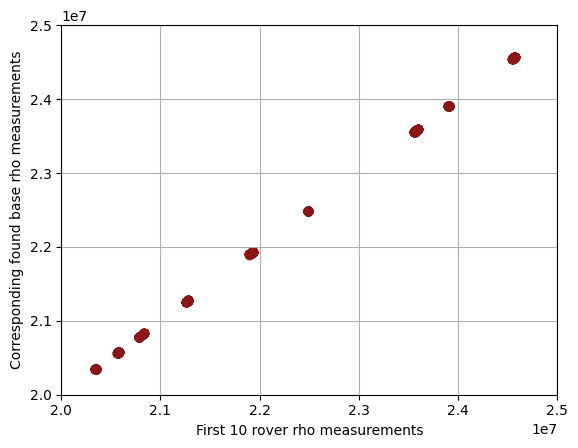

In [152]:
plt.scatter(rover_rho, base_rho)
plt.grid()
plt.xlabel('First 10 rover rho measurements')
plt.ylabel('Corresponding found base rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

### Calculate true ranges

In [153]:
BASE_STATION_LOCATION_1 = np.array([37.429711,-122.169381,25]).reshape(3, 1)
BASE_STATION_LOCATION_2 = np.array([37.4290631,-122.1723136,25]).reshape(3, 1) # multipath test

DURAND = np.array([[37.426906], [-122.173278], [21.010]]) 

In [154]:
matched_base_data

[array([ 0.00000000e+00,  1.73189115e+12,  2.56590199e+10,  1.80000000e+01,
                    nan, -1.41592634e+18,  0.00000000e+00,  1.03855247e+01,
                    nan,             nan,  4.19510000e+04,  2.00000000e+00,
         0.00000000e+00,  1.63990000e+04,  8.95679203e+13,  1.30000000e+01,
         3.52099991e+01,  1.19668510e+02,  9.76562500e-02,  1.70000000e+01,
        -1.16667323e+04,  1.64199561e-01,  1.57542003e+09,             nan,
                    nan,             nan,  0.00000000e+00,             nan,
         0.00000000e+00,  5.19999981e+00,  3.20000000e+01, -1.76951289e+01,
                    nan, -1.76951289e+01,             nan,  0.00000000e+00,
         4.01536633e+14,  1.00000000e+00,  0.00000000e+00,  1.41592637e+12,
         2.39012781e+07,  3.89730195e+00]),
 array([ 0.00000000e+00,  1.73189115e+12,  2.56590199e+10,  1.80000000e+01,
                    nan, -1.41592634e+18,  0.00000000e+00,  1.03855247e+01,
                    nan,             nan,  4

In [190]:
gps_millis_column = -3
sv_id_column = 11
gnss_id_column = -13

In [192]:
matched_base_data_clean = np.zeros((len(matched_base_data),len(matched_base_data[0])))
for i in range(len(matched_base_data)):
    print(matched_base_data[i])
    matched_base_data_clean[i, :] = matched_base_data[i]
    matched_base_data_clean[i, gnss_id_column] = 100.0

[ 0.00000000e+00  1.73189115e+12  2.56590199e+10  1.80000000e+01
             nan -1.41592634e+18  0.00000000e+00  1.03855247e+01
             nan             nan  4.19510000e+04  2.00000000e+00
  0.00000000e+00  1.63990000e+04  8.95679203e+13  1.30000000e+01
  3.52099991e+01  1.19668510e+02  9.76562500e-02  1.70000000e+01
 -1.16667323e+04  1.64199561e-01  1.57542003e+09             nan
             nan             nan  0.00000000e+00             nan
  0.00000000e+00  5.19999981e+00  3.20000000e+01 -1.76951289e+01
             nan -1.76951289e+01             nan  0.00000000e+00
  4.01536633e+14  1.00000000e+00  0.00000000e+00  1.41592637e+12
  2.39012781e+07  3.89730195e+00]
[ 0.00000000e+00  1.73189115e+12  2.56590199e+10  1.80000000e+01
             nan -1.41592634e+18  0.00000000e+00  1.03855247e+01
             nan             nan  4.19510000e+04  7.00000000e+00
  0.00000000e+00  1.63910000e+04  8.95679214e+13  1.50000000e+01
  3.20099983e+01  5.59765259e+02  1.20563284e-01  1.6000

In [193]:
# TODO: DEAL WITH THESE BOIS
np.where(np.isnan(matched_base_data_clean[:, gps_millis_column]) == True)[0]

array([241, 251, 261, 271, 281, 291, 301])

In [167]:
## Load the RinexNav data for that day
rinex_nav_paths = glp.load_ephemeris(
    "rinex_nav",
    np.array(np.nanmin(matched_base_data_clean[:, gps_millis_column]),np.nanmax(matched_base_data_clean[:, gps_millis_column])),
    verbose=True,
)
rinex_nav = glp.RinexNav(rinex_nav_paths, verbose=True)

ephemeris dates needed: [datetime.date(2024, 11, 17), datetime.date(2024, 11, 18)]
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx


In [196]:
GNSS_ID_FLOAT = 100.0
def find_sv_pos(rinex, sv_id, gnss_id, gps_millis):
    """ finding sv position with ephemeris data FOR DURAND receiver"""
    n = len(sv_id)
    position_info = np.zeros((n, 3))
    for i in range(n):
        sv_at_millis = glp.find_sv_states(gps_millis[i], rinex)
        cropped_sv_at_millis = sv_at_millis.where('sv_id', sv_id[i], 'eq')
        gnss_id_at_millis = cropped_sv_at_millis.where('gnss_id', 'gps', 'eq')
        # TODO: JANK PLS FIX AND DO SOMETHING SMARTER
        position_info[i, 0] = np.mean(gnss_id_at_millis['x_sv_m'])
        position_info[i, 1] = np.mean(gnss_id_at_millis['y_sv_m'])
        position_info[i, 2] = np.mean(gnss_id_at_millis['z_sv_m'])
    return position_info

# FOR DURAND DATA
# def get_measured_pseudorange(df,sv_id):
#     """ get measured pseudorange of specific sv for durand receiver"""
#     filtered_df = df[df.iloc[:,4] == str(sv_id)]
#     return filtered_df.iloc[:,14]

def distance_to_groundtruth(sv_pos, ground_truth):
    """ calculate ground truth distance from SV to Durand receiver"""
    gt_ecef = glp.geodetic_to_ecef(ground_truth)
    distance = np.linalg.norm(sv_pos[:, :, None] - gt_ecef[None, :, :], axis=1)
    return distance

def correction(true_range, base_pseudorange, rover_pseudorange):
    """ true_range: ground truth distance from distance_to_groundtruth function
    base_pseudorange: pseudorange for base station
    pseudorange: pseudorange for phone """
    e = true_range - base_pseudorange
    adjusted_pseudorange = rover_pseudorange + e
    return adjusted_pseudorange



# def get_pseudorange(raw_data, sv_id):
#     """ get measure pseudorange of the rover with specified sv_id"""
#     cropped_data = raw_data.where("sv_id", sv_id, "eq")
#     pseudorange = compute_pseudoranges(cropped_data)
#     return pseudorange

In [197]:

sv_pos = find_sv_pos(rinex_nav, matched_base_data_clean[:, sv_id_column], matched_base_data_clean[:, gnss_id_column], matched_base_data_clean[:, gps_millis_column])

# sv_pos = find_sv_pos(rover_ephemeris, 6)
# true_ranges = distance_to_groundtruth()

/home/gigavoltflash/miniconda3/lib/python3.9/site-packages/gnss_lib_py/utils/time_conversions.py:119: RuntimeWarning: invalid value encountered in cast
  gps_weeks.append(np.int64(gps_week))
/home/gigavoltflash/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gigavoltflash/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Actual dGNSS shit

In [203]:
length = 100
# base_pseudorange_unmatched = compute_pseudoranges(base_data_gps_only)
true_range = distance_to_groundtruth(sv_pos, BASE_STATION_LOCATION_1).flatten()
# rover_pseudorange = compute_pseudoranges(rover_data_gps_only)
corrected_pseudorange = correction(true_range, base_rho, rover_rho)

## are we matching rover and base SVs

In [204]:
corrected_pseudorange

array([23807555.97442874, 23549348.94391401, 21027797.81896965,
       20728802.06687644, 22560358.61673781, 20518784.41347662,
       22105069.53799666, 24576554.44031383, 20757387.77813202,
       21172902.44103774, 23807661.20158149, 23549901.76120656,
       21027894.35214112, 20728965.45376604, 22560247.09394343,
       20518637.81496466, 22104497.83377926, 24576897.10309332,
       20757420.45550994, 21173242.70547757, 23807772.72437587,
       23550437.49032901, 21027992.08448243, 20729131.83858024,
       22560125.37820548, 20518475.32745242, 22103929.12748643,
       24577225.37583483, 20757457.03018982, 21173593.16286097,
       23807870.45671718, 23550994.50471597, 21028087.71827653,
       20729293.42671509, 22560013.25582619, 20518314.93848739,
       22103361.02077853, 24577559.04484059, 20757486.11005825,
       21173931.62854606, 23807972.98573782, 23551509.84795127,
       21028200.7400332 , 20729463.10924632, 22559908.32846589,
       20518168.93956035, 22102796.51158

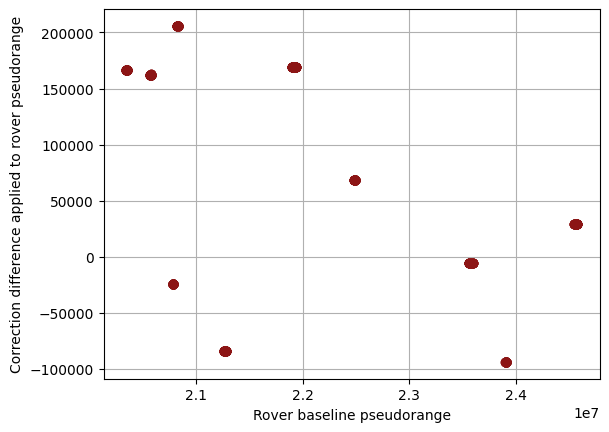

In [208]:
plt.scatter(rover_rho, corrected_pseudorange - rover_rho)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('Correction difference applied to rover pseudorange')
plt.grid()

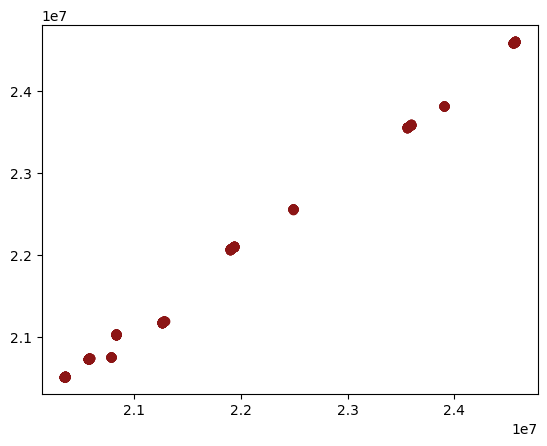

In [205]:
plt.scatter(rover_rho, corrected_pseudorange)

### Newton Raphson to solve for position

In [220]:
# Define four arrays

x = sv_pos[:40, 0]
y = sv_pos[:40, 1]
z = sv_pos[:40, 2]

# Create DataFrame using the arrays
df = pd.DataFrame({
    'x_sv_m': x,
    'y_sv_m': y,
    'z_sv_m': z,
    'corr_pr_m': corrected_pseudorange[:40]
})

# Create DataFrame using the arrays
df_raw = pd.DataFrame({
    'x_sv_m': x,
    'y_sv_m': y,
    'z_sv_m': z,
    'corr_pr_m': rover_rho[:40]
})

# Create DataFrame using the arrays
df_base = pd.DataFrame({
    'x_sv_m': x,
    'y_sv_m': y,
    'z_sv_m': z,
    'corr_pr_m': base_rho[:40]
})

In [221]:
import numpy as np
import pandas as pd

def newton_raphson(x0, bu_0, max_iterations, dataset):
    """
    Function description: perform newton raphson to compute position of observer based on available satellite
    data, stop function when we have updates in delta_x, delta_bu that are less than a centimeter,
    or hit maximum number of iterations

    Inputs:
    1) x_0: initial guess for position
    2) bu_0: initial guess for clock bias
    3) max_iterations: maximum number of iterations until covergence
    4) dataset_name: name of file to read in

    return: 
    1) optimized position
    2) optimized clock bias
    3) number of iterations until covergence
    """
    x_est = x0
    b_est = bu_0


    for i in range(max_iterations):

        # Get Geometry Matrix and deltas for rho
        geometry_matrix = []
        delta_rho = []
        for index, sat in dataset.iterrows():
            geometry_matrix.append(get_geometry_row(x_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))
            delta_rho.append(sat['corr_pr_m'] - get_theoretical_pseudoranges(x_est, b_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))

        # Convert into matricies to make it easier to use numpy functions
        geometry_matrix = np.array(geometry_matrix)
        delta_rho = np.array(delta_rho)

        # Update the deltas
        delta_x, delta_bu = newton_raphson_step(geometry_matrix, delta_rho)
        x_est = np.add(x_est, delta_x)
        b_est = b_est + delta_bu
    
        if True: #i%10 == 0:
            print("round: ",i+1)
            print("x_est: ", x_est)
            print("b_est: ", b_est)

        if delta_x[0] < 0.01 and delta_x[1] < 0.01 and delta_x[2] < 0.01 and delta_bu < 0.01:
            break
    
    
    print("round: ",i+1)
    print("FINAL - x_est: ", x_est)
    print("FINAL - b_est: ", b_est)
    return x_est


def get_geometry_row(x_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current guess for current position estimate 
    2) x_sv_m: a set for satellite position x
    3) y_sv_m: a set for satellite position y
    4) z_sv_m: a set for satellite position z


    return: 
    1) Geometry Matrix G (first 3 columns unit vector)
    """

    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)

    return ([-x/magnitude, -y/magnitude, -z/magnitude, 1])



def get_theoretical_pseudoranges(x_est, b_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current position estimate 
    2) b_est: current clock bias estimate 
    3) x_sv_m: a set for satellite position x
    4) y_sv_m: a set for satellite position y
    5) z_sv_m: a set for satellite position z

    return: 
    1) Theoretical pseudorange measurement vector
    """


    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)
    b_k = 0 # assume its zero for all satellites, already corrrected for in data

    return magnitude + b_est - b_k

def newton_raphson_step(G,delta_rho):
    """
    Function description: Take one step of newton-raphson optimization, compute update of 
    delta_x and delta_bu

    Input:
    1) G: geometry matrix
    2) delta_rho: difference of theoretical and measured pseudoranges 

    return:
    1) delta_x
    2) delta_bu
    """
    G_t = G.transpose()
    deltas = np.matmul(np.matmul(np.linalg.inv(np.matmul(G_t, G)),G_t),delta_rho)

    delta_x = deltas[0:3]
    delta_bu = deltas[3]

    return delta_x, delta_bu

In [222]:
import gnss_lib_py as glp

df_cleaned = df.dropna()
x = newton_raphson([0,0,0],0,30,df_cleaned)

print("Lat/Long Version: ",glp.ecef_to_geodetic(x))

round:  1
x_est:  [-3190587.82220755 -5150122.81776331  4662261.59918637]
b_est:  1319692.4175641888
round:  2
x_est:  [-2713341.12071571 -4320187.65930694  3883368.78904911]
b_est:  45381.12537553045
round:  3
x_est:  [-2700329.4850405  -4292599.40134705  3855313.95980463]
b_est:  93.71351282205433
round:  4
x_est:  [-2700317.16601416 -4292568.13108854  3855280.49189983]
b_est:  43.131631697560586
round:  5
x_est:  [-2700317.16602134 -4292568.13103343  3855280.4919284 ]
b_est:  43.13159136170819
round:  5
FINAL - x_est:  [-2700317.16602134 -4292568.13103343  3855280.4919284 ]
FINAL - b_est:  43.13159136170819
Lat/Long Version:  [[  37.42835772 -122.1726836    45.44547064]]


In [223]:
import gnss_lib_py as glp

df_raw_cleaned = df_raw.dropna()
x_raw = newton_raphson([0,0,0],0,30,df_raw_cleaned)

print("Lat/Long Version: ",glp.ecef_to_geodetic(x_raw))

round:  1
x_est:  [-3331102.56050596 -5156745.74971485  4660837.69408667]
b_est:  1290909.0659492943
round:  2
x_est:  [-2837296.10775567 -4329521.4077054   3881746.42641187]
b_est:  6959.106791937258
round:  3
x_est:  [-2823411.6087887  -4301447.76734281  3853487.21774694]
b_est:  -38925.972640728796
round:  4
x_est:  [-2823381.17963354 -4301397.98426987  3853441.26556738]
b_est:  -38994.016448731185
round:  5
x_est:  [-2823381.1417137  -4301397.94125218  3853441.25026852]
b_est:  -38994.049267037626
round:  6
x_est:  [-2823381.14165622 -4301397.94120321  3853441.25028011]
b_est:  -38994.04929426002
round:  6
FINAL - x_est:  [-2823381.14165622 -4301397.94120321  3853441.25028011]
FINAL - b_est:  -38994.04929426002
Lat/Long Version:  [[ 3.70139160e+01 -1.23280369e+02  5.78310654e+04]]


In [224]:
import gnss_lib_py as glp

df_base_cleaned = df_base.dropna()
x_base = newton_raphson([0,0,0],0,30,df_base_cleaned)

print("Lat/Long Version: ",glp.ecef_to_geodetic(x_base))

round:  1
x_est:  [-3330759.85640497 -5156847.35342593  4660962.24327086]
b_est:  1290882.7360890512
round:  2
x_est:  [-2836990.17215512 -4329584.46068325  3881858.48335244]
b_est:  6918.956756890984
round:  3
x_est:  [-2823105.98589166 -4301509.73809983  3853594.34443035]
b_est:  -38969.23190203652
round:  4
x_est:  [-2823075.55137709 -4301459.97405999  3853548.2875266 ]
b_est:  -39037.314361366516
round:  5
x_est:  [-2823075.5135496  -4301459.93099223  3853548.27192497]
b_est:  -39037.34731761267
round:  6
x_est:  [-2823075.51349247 -4301459.93094345  3853548.27193602]
b_est:  -39037.34734491812
round:  6
FINAL - x_est:  [-2823075.51349247 -4301459.93094345  3853548.27193602]
FINAL - b_est:  -39037.34734491812
Lat/Long Version:  [[ 3.70153020e+01 -1.23277145e+02  5.78029679e+04]]
